# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第31节 资金仓位管理与买入策略的搭配</b></font>
</center>

-----------------

作者: 阿布

阿布量化版权所有 未经允许 禁止转载

[abu量化系统github地址](https://github.com/bbfamily/abu) (欢迎+star)

[本节ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)


上一节讲解了趋势跟踪与均值回复的长短线搭配的示例，本节讲解资金仓位管理与买入策略的搭配。

首先导入本节需要使用的abupy中的模块： 

In [1]:
# 基础库导入

from __future__ import print_function
from __future__ import division

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/csv


In [2]:
from abupy import AbuDownUpTrend, AbuPtPosition, ABuMarketDrawing
from abupy import AbuFactorCloseAtrNStop, AbuFactorAtrNStop, AbuFactorPreAtrNStop, tl
from abupy import abu, ABuProgress, AbuMetricsBase, EMarketTargetType

abupy中的买策，卖策，选股，资管模块在内部都是面向对象的独立存在，只有使用者在顶层的调度是面向过程的，这种设计的目标是为上层使用者提供最大限度的自由，即通过代码实现整体策略的自由度，以及降低整体策略的复杂耦合度，便于后期维护升级扩张的需要。

在abupy定制整体策略的步骤如下：
1. 定性整体策略风格，必需(定性趋势策略或者回复策略) 
2. 定制买入信号策略，必需
3. 定制卖出信号策略，必需
4. 定制选股策略，可选
5. 定制资金仓位管理策略，可选
6. 定制滑点买入策略，可选（中低频回测可不涉及）

在abpy中对于一个完整的策略其中1，2，3是必需要做的，4，5，6是可以选择进行的工作，从abupy提供的回测ui可交互界面大体可看到组合一个整体个性化策略步骤需要，如下图：

![](./image/run_ui.png)

上一节讲解的通过买入和卖出策略的搭配定性整体策略风格为趋势跟踪策略或均值回复策略，即通过买入策略和卖出策略定性整体策略的交易风格，选股策略和资金管理策略的意义更多在与配合整体策略提高稳定可靠性，简单如下所示：

![](./image/st_mod.png)

备注：abupy中更关键技术是使用交易结果预测拦截ump模块对策略交易进行深度优化定制，本节暂不涉及，请阅读‘第15节 量化交易和搜索引擎’或之后的教程

关于定制选股策略相关内容在‘第27节 狗股选股策略与择时策略的配合’有完整示例，请阅读相关内容。

本节主要讲解针对整体策略风格体制资金仓位管理策略，abupy默认的仓位管理策略为atr资管策略，详请阅读‘第4节 多支股票择时回测与仓位管理’。

上一节使用了abupy内置的一个长短线买入策略AbuDownUpTrend：
1. 寻找长线下跌的股票，比如一个季度(4个月)整体趋势为下跌趋势
2. 短线走势上涨的股票，比如一个月整体趋势为上涨趋势
3. 最后使用海龟突破的N日突破策略作为策略最终买入信号

![](./image/du_trend.png)

本节针对这个策略示例定制一个对应的资管策略。

本示例资管策略原理很简单，如下图所示：

如果AbuDownUpTrend策略设置不同的参数将有可能在buy A或buy B两个位置发出买入信号，那么资管策略将根据前期最高点位置3067做为值'100'定位当前买入价格的位置，很明显buy B的买入位置要高于buy A的买入位置，那么：

* buy A点的买入仓位配比会高(认为均值回复有很大向上空间)
* buy B点的买入仓位配比会低(认为均值回复向上空间比较小)

![](./image/pos_trend.png)

资管仓位策略不需要考虑买入点是否合理以及何时卖出，只需要关注在buy a点buy b应该如何对资金仓位进行配比，策略模块之间尽量减少耦合度。

上述策略简单举例代码描述如下:

1. 价格价格曲线由10下跌到5后上涨到9
2. 如果买入点buy_a的位置为7，则相对最高点价格位置：45.0
3. 如果买入点buy_b的位置为9，则相对最高点价格位置：85.0
4. buy A点的买入仓位配比会高(认为均值回复有很大向上空间)
5. buy B点的买入仓位配比会低(认为均值回复向上空间比较小)

如下所示：

buy_a 点相对最高点价格位置：45.0
buy_b 点相对最高点价格位置：85.0


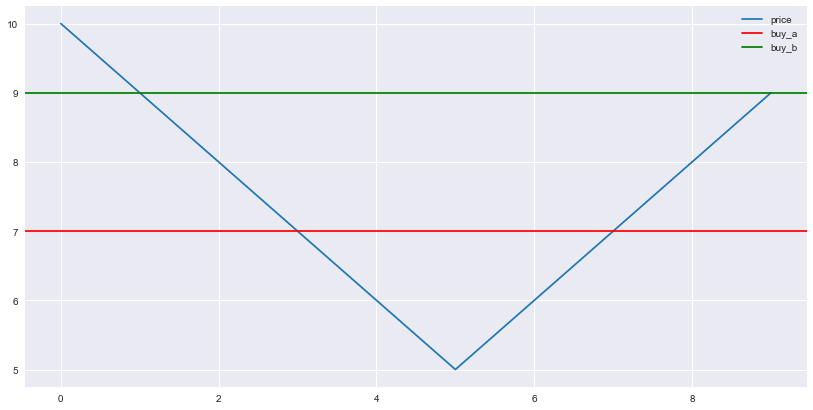

In [3]:
from scipy import stats
price = [10, 9, 8, 7, 6, 5, 6, 7, 8, 9]
buy_a = 7
buy_b = 9
plt.plot(price, label='price')
plt.axhline(buy_a, c='r', label='buy_a')
plt.axhline(buy_b, c='g', label='buy_b')
plt.legend(loc='best')
print('buy_a 点相对最高点价格位置：{}'.format(stats.percentileofscore(price, buy_a)))
print('buy_b 点相对最高点价格位置：{}'.format(stats.percentileofscore(price, buy_b)))

下面首先依然使用默认的仓位管理策略对上一节的AbuDownUpTrend策略进行回测，打印出交易单，可以看到仓位管理策略为AbuAtrPosition，如下所示：

In [4]:
# 初始资金量
cash = 3000000
def run_loo_back(ps=None, n_folds=3, start=None, end=None):
    us_choice_symbols = ['usTSLA', 'usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 'usGOOG', 'usWUBA', 'usVIPS']
    abu_result_tuple, _ = abu.run_loop_back(cash,
                                       buy_factors,
                                       sell_factors,
                                       ps,
                                       start=start,
                                       end=end,
                                       n_folds=n_folds,
                                       choice_symbols=us_choice_symbols)
    ABuProgress.clear_output()
    return abu_result_tuple
        
# 买入策略使用AbuDownUpTrend
buy_factors = [{'class': AbuDownUpTrend}]
# 卖出策略：利润保护止盈策略+风险下跌止损+较大的止盈位
sell_factors = [{'stop_loss_n': 1.0, 'stop_win_n': 3.0,
                 'class': AbuFactorAtrNStop},
                {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
                {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}]
# 开始回测
abu_result_tuple = run_loo_back()
# 筛出有交易结果的
orders_pd_atr = abu_result_tuple.orders_pd[abu_result_tuple.orders_pd.result != 0]
orders_pd_atr.filter(['buy_cnt', 'buy_pos', 'buy_price', 'profit', 'result'])

,buy_cnt,buy_pos,buy_price,profit,result
2014-02-28,17024.0,AbuAtrPosition,17.5845,-41700.29,-1
2014-06-11,6405.0,AbuAtrPosition,43.8950,35964.08,1
2014-06-13,26653.0,AbuAtrPosition,14.6100,15725.27,1
2014-11-03,9261.0,AbuAtrPosition,40.0150,24333.28,1
2015-04-09,40713.0,AbuAtrPosition,7.4200,19949.37,1
2015-06-04,2959.0,AbuAtrPosition,202.7500,-6376.65,-1
2015-10-20,2798.0,AbuAtrPosition,153.2500,152560.95,1


abupy内置的资管AbuPtPosition策略为上述策略的代码实现, 详代码请阅读源代码，关键策略代码如下:
    
        def fit_position(self, factor_object):
            """
            针对均值回复类型策略的仓位管理：
            根据当前买入价格在过去一段金融序列中的价格rank位置来决定仓位
            fit_position计算的结果是买入多少个单位（股，手，顿，合约）
            :param factor_object: ABuFactorBuyBases子类实例对象
            :return:买入多少个单位（股，手，顿，合约）
            """
            # self.kl_pd_buy为买入当天的数据，获取之前的past_day_cnt天数据
            last_kl = factor_object.past_today_kl(self.kl_pd_buy, self.past_day_cnt)
            if last_kl is None or last_kl.empty:
                precent_pos = self.pos_base
            else:
                # 使用percentileofscore计算买入价格在过去的past_day_cnt天的价格位置
                precent_pos = stats.percentileofscore(last_kl.close, self.bp)
                precent_pos = (1 + (self.mid_precent - precent_pos) / 100) * self.pos_base
            # 最大仓位限制，依然受上层最大仓位控制限制，eg：如果算出全仓，依然会减少到75%，如修改需要修改最大仓位值
            precent_pos = self.pos_max if precent_pos > self.pos_max else precent_pos
            # 结果是买入多少个单位（股，手，顿，合约）
            return self.read_cash * precent_pos / self.bp * self.deposit_rate
            
下面使用同样的买入卖出策略，但是资管策略使用AbuPtPosition进行回测，如下：

In [5]:
# 买策还是AbuDownUpTrend，但资管类字段position使用AbuPtPosition做为策略
buy_factors = [{'class': AbuDownUpTrend, 'position': {'class': AbuPtPosition, 'past_day_cnt': 80}}]
abu_result_tuple = run_loo_back()
# 筛出有交易结果的
orders_pd_precent = abu_result_tuple.orders_pd[abu_result_tuple.orders_pd.result != 0]
orders_pd_precent.filter(['buy_cnt', 'buy_pos', 'buy_price', 'profit', 'result'])

,buy_cnt,buy_pos,buy_price,profit,result
2014-02-28,17060.0,AbuPtPosition,17.5845,-41788.47,-1
2014-06-11,5382.0,AbuPtPosition,43.8950,30219.93,1
2014-06-13,17197.0,AbuPtPosition,14.6100,10146.23,1
2014-11-03,7684.0,AbuPtPosition,40.0150,20189.71,1
2015-04-09,26280.0,AbuPtPosition,7.4200,12877.20,1
2015-06-04,1849.0,AbuPtPosition,202.7500,-3984.60,-1
2015-10-20,1957.0,AbuPtPosition,153.2500,106705.43,1


对比上面两处交易单输出结果可以发现在buy_pos处使用的资管策略不同，导致在buy_cnt上资金仓位配比发生了变化。

#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)

abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/tree/master/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/tree/master/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/tree/master/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/tree/master/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/tree/master/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/tree/master/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/tree/master/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/tree/master/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/tree/master/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/tree/master/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/tree/master/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/tree/master/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/tree/master/ipython/附录C-量化统计分析及指标应用.ipynb)

[更多阿布量化量化技术文章](http://www.abuquant.com/article)


更多关于量化交易相关请阅读[《量化交易之路》](http://www.abuquant.com/books/quantify-trading-road.html)

更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://www.abuquant.com/books/machine-learning-road.html)

更多关于abu量化系统请关注微信公众号: abu_quant

![](./image/qrcode.jpg)